In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

/kaggle/input/fake-news-detection-dataset/Task3_english_training.csv
/kaggle/input/fake-news-detection-dataset/Task3_english_dev.csv
/kaggle/input/fake-news-detection-dataset/English_data_test_release_with_rating.csv
  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=c3f781fa6a426577b93b13cc880e458e8e013b323dae4397eeefbb116c6743ae
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% |  1% |
|  1 |  0% |  0% |


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_train = pd.read_csv('/kaggle/input/fake-news-detection-dataset/Task3_english_training.csv')
data_validation = pd.read_csv('/kaggle/input/fake-news-detection-dataset/Task3_english_dev.csv')
data_test = pd.read_csv('/kaggle/input/fake-news-detection-dataset/English_data_test_release_with_rating.csv')

combined_data = pd.concat([data_train, data_validation, data_test], ignore_index=True)

combined_data['our rating'] = combined_data['our rating'].str.lower()

def makeLabelsUnique(labels):
    unique_labels = set(labels)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    labels = [label_map[label] for label in labels]
    return labels

combined_data['our rating'] = makeLabelsUnique(combined_data['our rating'].values)

train_df, val_df = train_test_split(combined_data, test_size=0.20, random_state=42, shuffle=True)

In [3]:
import torch 

def calculate_class_weights(labels):
    
    labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels

    num_classes = torch.unique(labels).numel()

    class_counts = torch.zeros(num_classes)
    for label in labels:
        class_counts[label] += 1

    class_weights = 1.0 / class_counts

    class_weights = class_weights / class_weights.sum()

    return class_weights

labels = train_df['our rating'].tolist()  
weights = calculate_class_weights(labels)
print("Class weights:", weights)

Class weights: tensor([0.0889, 0.1867, 0.5409, 0.1835])


In [4]:
train_df = train_df[[ 'text','title', 'our rating']].copy()
val_df = val_df[['text', 'title', 'our rating']].copy()

train_dataset = train_df.reset_index(drop=True)
val_dataset = val_df.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VAL Dataset: {}".format(val_dataset.shape))

TRAIN Dataset: (1500, 3)
VAL Dataset: (376, 3)


In [5]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  
print(nltk.data.path)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [6]:
import re
from nltk.corpus import stopwords
import emoji

nltk.download('stopwords')

def preprocess_text(text, remove_hashtags=False, remove_users=False, remove_urls=False, lower_case=False,  remove_stopwords=False):
    text = emoji.demojize(text, language='en')
    
    if lower_case:
        text = text.lower()

    if remove_hashtags:
        words = [word for word in words if not word.startswith('#')]
        text = ' '.join(words)

    if remove_users:
        words = [word for word in words if not word.startswith('@')]
        text = ' '.join(words)

    if remove_urls:
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn
from torch.nn.utils.rnn import pad_sequence

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512, overlap=50, transforms=None):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['text'].apply(preprocess_text)
        self.titles = dataframe['title']
        self.labels = dataframe['our rating']
        self.max_len = max_len
        self.overlap = overlap
        self.transforms = transforms

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        title = str(self.titles[idx])
        label = self.labels[idx]

        if self.transforms:
            text = self.transforms(text)
        
        combined_text = title + " [SEP] " + text

        encoded = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            return_token_type_ids=True,
            truncation=True,
            max_length=self.max_len,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded['input_ids'].squeeze()

        windows = []
        start = 0
        while start < len(input_ids):
            end = min(start + self.max_len, len(input_ids))  
            window = input_ids[start:end]
            windows.append(window)
            if end == len(input_ids):
                break  
            start += (self.max_len - self.overlap)

        return {'windows': windows, 'label': torch.tensor(label, dtype=torch.long)}

def collate_fn(batch):
    windows_batch = [item['windows'] for item in batch]
    labels_batch = torch.stack([item['label'] for item in batch])
    window_counts = [len(windows) for windows in windows_batch]

    windows_flat = [win for sublist in windows_batch for win in sublist]
    padded_windows = pad_sequence(windows_flat, batch_first=True, padding_value=0)
    
    return {'windows': padded_windows, 'labels': labels_batch, 'window_counts': window_counts}

train_dataset = CustomDataset(train_dataset, tokenizer, transforms= None)
val_dataset = CustomDataset(val_dataset, tokenizer)

In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset),  
    batch_size=batch_size,  
    collate_fn=collate_fn 
)

val_dataloader = DataLoader(
    val_dataset, 
    sampler=SequentialSampler(val_dataset),  
    batch_size=batch_size,  
    collate_fn=collate_fn  
)

In [11]:

class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes, dropout_rate=0.2):
        super(BertClassifier, self).__init__()
        self.bert = bert_model  # Load a pre-trained BERT model.
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(self.bert.config.hidden_size, 64)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.classifier = nn.Linear(64, num_classes)  

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, window_counts=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)

        dense_output = self.dense(pooled_output)
        dense_output = torch.tanh(dense_output)
        dense_output = self.dropout2(dense_output)

        if window_counts is not None:
            start_index = 0
            aggregated_outputs = []
            for count in window_counts:
                
                aggregated_output = pooled_output[start_index:start_index + count].mean(dim=0)
                aggregated_outputs.append(aggregated_output)
                start_index += count
            aggregated_outputs = torch.stack(aggregated_outputs)
        else:
            aggregated_outputs = pooled_output

        logits = self.classifier(dense_output)
        return logits

bert_model = BertModel.from_pretrained('bert-base-uncased')
num_classes = 4
model = BertClassifier(bert_model, num_classes).to(device)

LEARNING_RATE = 5e-5

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Starting Epoch 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
New best model saved with accuracy: 26.329787234042552%
Completed Epoch 0, Training Loss: 2.7983673988504614, Training Accuracy: 30.266666666666666%
Validation Loss: 2.761710693438848, Validation Accuracy: 26.329787234042552%
Early stopping counter: 0/5
Starting Epoch 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
New best model saved with accuracy: 46.01063829787234%
Completed Epoch 1, Training Loss: 2.667563443488263, Training Accuracy: 43.46666666666667%
Validation Loss: 2.625021825234095, Validation Accuracy: 46.01063829787234%
Early stopping counter: 0/5
Starting Epoch 2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
New best model saved with accuracy: 53.4574468085

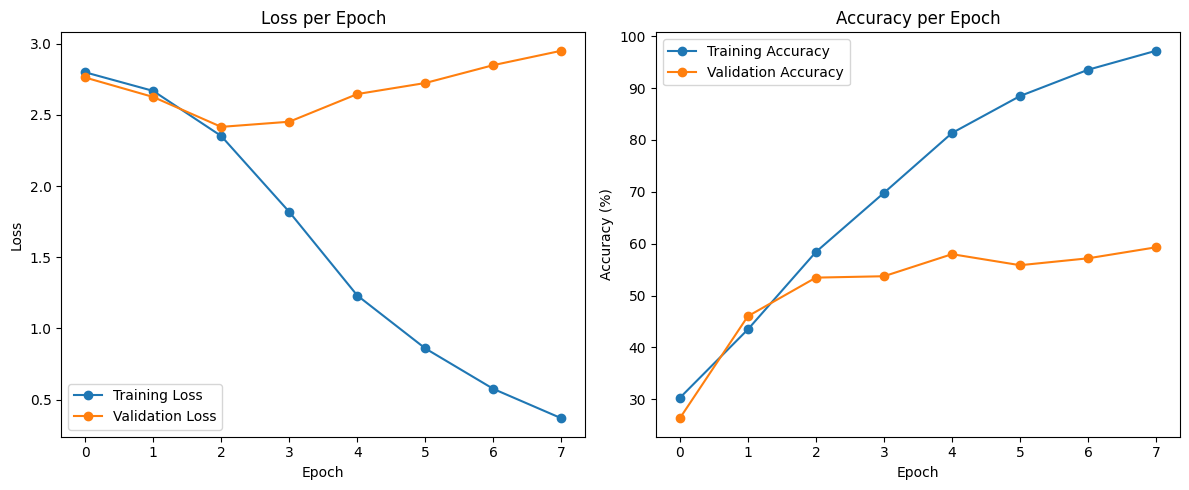

In [12]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.metrics import accuracy_score
import gc

torch.cuda.empty_cache()
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

def train_model(model, dataloader, val_dataloader, optimizer, weights, num_epochs=200, 
                save_path='/kaggle/working/model.pth', gradient_accumulation_steps=4,
                patience=5, min_delta=0.001):
    weights = weights.to(device)  
    model.train()
    epoch_losses = []  
    epoch_accuracies = []  
    epoch_val_losses = []
    epoch_val_accuracies = []
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    best_accuracy = 0

    best_val_loss = float('inf')
    patience_counter = 0
    early_stop = False
    
    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping triggered")
            break
        print(f"Starting Epoch {epoch}")
        batch_count = 0
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        optimizer.zero_grad()
        
        for idx, batch in enumerate(dataloader):
            batch_count += 1
            print(batch_count)
            
            torch.cuda.empty_cache()
            gc.collect()
            
            input_ids = batch['windows'].to(device)
            labels = batch['labels'].to(device)
            window_counts = batch['window_counts']

            attention_mask = (input_ids != 0).type(torch.long).to(device)

            batch_size = input_ids.size(0)
            sub_batch_size = batch_size // 2  
            
            total_batch_loss = 0
            for i in range(0, batch_size, sub_batch_size):
                end_idx = min(i + sub_batch_size, batch_size)
                sub_input_ids = input_ids[i:end_idx]
                sub_attention_mask = attention_mask[i:end_idx]
                sub_labels = labels[i:end_idx]
                
                outputs = model(sub_input_ids, 
                              attention_mask=sub_attention_mask, 
                              window_counts=window_counts)
                
                loss = loss_fn(outputs, sub_labels)
                loss = loss / gradient_accumulation_steps
                loss.backward()
                
                total_batch_loss += loss.item()
                
                predictions = outputs.argmax(dim=1)
                correct_predictions += (predictions == sub_labels).sum().item()
                total_predictions += sub_labels.size(0)
                
                del outputs, sub_input_ids, sub_attention_mask, sub_labels
                torch.cuda.empty_cache()
            
            if (idx + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            total_loss += total_batch_loss * gradient_accumulation_steps

        average_loss = total_loss / batch_count
        epoch_losses.append(average_loss)
        epoch_accuracy = 100 * correct_predictions / total_predictions
        epoch_accuracies.append(epoch_accuracy)
        
        model.eval()
        with torch.no_grad():
            total_loss = 0
            correct_predictions = 0
            total_predictions = 0
            
            for batch in val_dataloader:
                torch.cuda.empty_cache()
                input_ids = batch['windows'].to(device)
                labels = batch['labels'].to(device)
                attention_mask = (input_ids != 0).type(torch.long).to(device)

                batch_size = input_ids.size(0)
                sub_batch_size = batch_size // 2
                
                batch_loss = 0
                for i in range(0, batch_size, sub_batch_size):
                    end_idx = min(i + sub_batch_size, batch_size)
                    sub_input_ids = input_ids[i:end_idx]
                    sub_attention_mask = attention_mask[i:end_idx]
                    sub_labels = labels[i:end_idx]
                    
                    outputs = model(sub_input_ids, attention_mask=sub_attention_mask)
                    loss = loss_fn(outputs, sub_labels)
                    batch_loss += loss.item()
                    
                    predictions = outputs.argmax(dim=1)
                    correct_predictions += (predictions == sub_labels).sum().item()
                    total_predictions += sub_labels.size(0)
                    
                    del outputs, sub_input_ids, sub_attention_mask, sub_labels
                
                total_loss += batch_loss

            epoch_val_losses.append(total_loss / len(val_dataloader))
            epoch_val_accuracies.append(100 * correct_predictions / total_predictions)
    
        current_accuracy = epoch_val_accuracies[-1]
        current_val_loss = epoch_val_losses[-1]
        
        if current_val_loss < (best_val_loss - min_delta):
            best_val_loss = current_val_loss
            patience_counter = 0
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy
                torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
                print(f"New best model saved with accuracy: {best_accuracy}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                early_stop = True
        
        print(f"Completed Epoch {epoch}, Training Loss: {epoch_losses[-1]}, Training Accuracy: {epoch_accuracies[-1]}%")
        print(f"Validation Loss: {epoch_val_losses[-1]}, Validation Accuracy: {epoch_val_accuracies[-1]}%")
        print(f"Early stopping counter: {patience_counter}/{patience}")
        
        torch.cuda.empty_cache()
        gc.collect()

    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return epoch_losses, epoch_accuracies, epoch_val_losses, epoch_val_accuracies

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model.to(device)

epoch_train_losses, epoch_train_accuracies, epoch_val_losses, epoch_val_accuracies = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    optimizer, 
    weights, 
    num_epochs=200, 
    save_path='/kaggle/working/model.pth',
    patience=5, 
    min_delta=0.001  
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_losses, label='Training Loss', marker='o')
plt.plot(epoch_val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epoch_val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Validation Accuracy: 0.5930851063829787
Validation F1 Score (Micro): 0.5930851063829787
Validation F1 Score (Macro): 0.5220155688331876


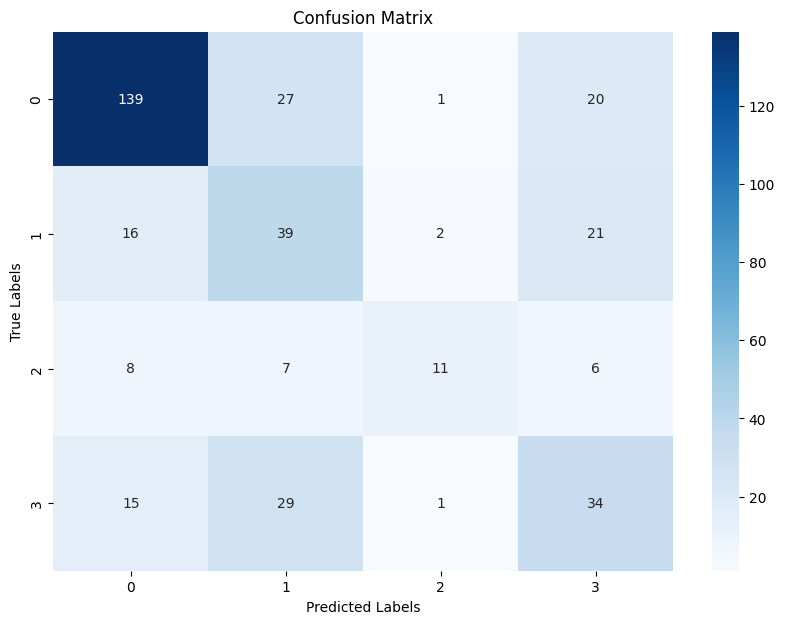

In [13]:
import torch
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def validation_and_plot(model, dataloader, device):
    model.eval()  
    fin_targets = []
    fin_outputs = []
    with torch.no_grad(): 
        for _, data in enumerate(dataloader):
            input_ids = data['windows'].to(device)
            labels = data['labels'].to(device)
            attention_mask = (input_ids != 0).type(torch.long)

            outputs = model(input_ids, attention_mask=attention_mask)
            outputs = outputs.logits if hasattr(outputs, 'logits') else outputs

            fin_targets.extend(labels.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.argmax(outputs, dim=1).cpu().detach().numpy().tolist())

    accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
    f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro')
    print(f"Validation Accuracy: {accuracy}")
    print(f"Validation F1 Score (Micro): {f1_score_micro}")
    print(f"Validation F1 Score (Macro): {f1_score_macro}")

    cm = confusion_matrix(fin_targets, fin_outputs)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_and_plot(model, val_dataloader, device)